# Extract Comments

In [ ]:
from utils import fetch_comments , extract_youtube_video_id
import os
api_key = os.getenv("YOUTUBE_API_KEY")
video_id = extract_youtube_video_id("https://www.youtube.com/watch?v=cIla9axQRyM&t=69s"  )
comments = fetch_comments(video_id,api_key=api_key, max_comments=500)
comments


c:\Users\prana\Desktop\PROJECTS\yt-comment-streamlit\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026/01/19 13:11:25 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 3.8.1, required: mlflow==2.15.0)
 - cffi (current: 2.0.0, required: cffi==1.16.0)
 - cloudpickle (current: 3.1.2, required: cloudpickle==3.0.0)
 - lightgbm (current: 4.6.0, required: lightgbm==4.5.0)
 - matplotlib (current: 3.10.8, required: matplotlib==3.9.1)
 - numpy (current: 2.4.1, required: numpy==1.26.4)
 - pandas (current: 2.3.3, required: pandas==2.2.2)
 - psutil (current: 7.2.1, required: psutil==6.0.0)
 - pyarrow (current: 22.0.0, required: pyarrow==15.0.2)
 - scikit-learn (current: 1.8.0, required: scikit-learn==1.5.1)
 

In [20]:
list_of_comments = [x["text"] for x in comments]
list_of_comments

['Thank you for watching. Please click the subscribe tab and then the "bell" icon to subscribe to our channel here on YouTube and get notified when new content is posted... And thank you for your interest in science!   -- Andrew',
 'This guy has turned- full on Generic. \nI pre-ordered  his book that was due out in a few mos, TWO YRS AGO!!  Nope, still not out. \nYou can’t leave comment on anything he vpn posts on social media, I wonder why. \nI liked him, now I want my money back and they are just using his voice in these video, nothing he says means anything anymore',
 'Maqui berries are the berries highest in anthocyanadins',
 'What about lions mane mushrooms for cognitive improvement? Also UCSF’s BrainHQ from Posit Science',
 "Hi Dr Huberman......new to the channel but seems genuinly produced after watching a few videos I think your standpoint on the issue is unbiased from an experiienced based caring person.\n\nYour field of study is an absolute revolutionaly important thing to ha

In [14]:
from typing  import List , Dict , TypedDict

class CommentsState(TypedDict):
    comments: List[str]
    topics: List[str]
    classified_comments: List[Dict[str, str]]

In [22]:
from dotenv  import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [24]:
# functions to process comments will go here
def topics_generator(state : CommentsState) -> CommentsState:
    # implement topic generation logic
    comments = state["comments"]
    prompt = f"""
    You are analyzing YouTube comments.

    TASK:
    - Identify 5–8 distinct discussion topics
    - Topics must be short noun phrases
    - Avoid overlap
    - Do NOT include sentiment

    COMMENTS:
    {comments}

    Return JSON only:
    {{
      "topics": ["topic1", "topic2", "..."]
    }}
    """
    response = llm.invoke(prompt)
    state["topics"] = response["topics"]
    return state

def classify_comments(state: CommentsState) -> CommentsState:
    topics = state["topics"]
    comments = state["comments"]

    prompt = f"""
    You are classifying YouTube comments into topics.

    TOPICS:
    {topics}

    RULES:
    - Each comment gets ONE topic
    - Use "Other" only if necessary

    COMMENTS:
    {comments}

    Return JSON only:
    [
      {{
        "comment": "...",
        "topic": "topic_name"
      }}
    ]
    """

    response = llm.invoke(prompt)
    state["classified_comments"] = response["topics"]
    return state

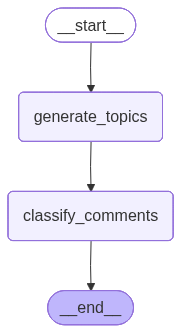

In [26]:
from langgraph.graph import StateGraph , START  , END

graph = StateGraph(CommentsState)
graph.add_node("generate_topics", topics_generator)
graph.add_node("classify_comments", classify_comments)

graph.add_edge(START , "generate_topics")
graph.add_edge("generate_topics", "classify_comments")
graph.add_edge("classify_comments", END)

workflow = graph.compile()
workflow

In [27]:
initial_state: CommentsState = {
    "comments": list_of_comments}

final_state = workflow.invoke(initial_state)   
final_state

TypeError: 'AIMessage' object is not subscriptable

# check

In [1]:
from pydantic import BaseModel, Field
from typing import TypedDict, List

class TopicState(TypedDict):
    comments: List[str]
    topics: List[str]
    classified_comments: List[dict]
    
class TopicDiscoveryOutput(BaseModel):
    topics: List[str] = Field(
        description="Short, non-overlapping topic names"
    )
    
class ClassifiedComment(BaseModel):
    comment: str
    topic: str


class TopicClassificationOutput(BaseModel):
    results: List[ClassifiedComment]


In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv  import load_dotenv
load_dotenv()
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.0
)

topic_discovery_llm = llm.with_structured_output(TopicDiscoveryOutput)
topic_classification_llm = llm.with_structured_output(TopicClassificationOutput)


In [16]:
def discover_topics(state: TopicState):
    comments_text = "\n".join(state["comments"][:100])

    prompt = f"""
You are analyzing YouTube comments.

TASK:
- Create discussion topics from the comments
- Topics must be created by you
- 2–3 words per topic
- No sentiment words
- Max 8 topics
- Dont Include  "Other" as a topic
COMMENTS:
{comments_text}
"""

    response = topic_discovery_llm.invoke(prompt)

    return {
        **state,
        "topics": response.topics
    }


In [26]:
def classify_comments(state: TopicState):
    comments_text = "\n".join(state["comments"])
    topics_text = ", ".join(state["topics"])

    prompt = f"""
You are classifying comments into topics.

TOPICS:
{topics_text}

RULES:
- Use ONLY the provided topics
- One topic per comment
- Do not invent new topics
- No explanations

COMMENTS:
{comments_text}
"""

    response = topic_classification_llm.invoke(prompt)

    return {
        **state,
        "classified_comments": [
            item.model_dump() for item in response.results
        ]
    }


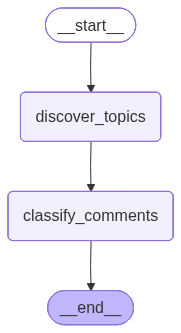

In [27]:
from langgraph.graph import StateGraph , START , END

graph = StateGraph(TopicState)

graph.add_node("discover_topics", discover_topics)
graph.add_node("classify_comments", classify_comments)

graph.add_edge(START , "discover_topics")
graph.add_edge("discover_topics", "classify_comments")
graph.add_edge("classify_comments" , END)
topic_graph = graph.compile()
topic_graph

In [28]:
#list
result = topic_graph.invoke({
    "comments": list_of_comments[10:20]
})

print("Discovered Topics:", result["topics"])
#print("Classified Comments:", result["classified_comments"])


Discovered Topics: ['Brain food pairing', 'Choline atropine effects', 'Taurine sclera bleeding', 'Alpha GPC alternatives', 'Hydration vitamin supplements', 'Subtitle language requests']


In [30]:
result['classified_comments']

[{'comment': '28:38 I’m confused here. So if we want to consume more of something because it’s good for our brain, we pair it with something we like? Or something that changes the brain’s metabolism? Or that is the thing the brain is seeking which is the first group of foods which we are trying to learn to like? “That other food” is what threw me off here. What falls in the category of “that other food”?',
  'topic': 'Brain food pairing'},
 {'comment': 'If Choline helps focus and atropine blocks it and creates hallucinations, is  choline the setting on a timing light and atropine changes the setting or the speed of the strobe light to see things that are going to slow or fast for choline to focus on?',
  'topic': 'Choline atropine effects'},
 {'comment': "I don't believe for one second that taurine caused bursting of microvasculature in your slcera. Just because your taking taurine was chronoogically associated with your sclera bleeding doesn't mean that it was the cause of it. You are

In [31]:
result

{'comments': ['28:38 I’m confused here. So if we want to consume more of something because it’s good for our brain, we pair it with something we like? Or something that changes the brain’s metabolism? Or that is the thing the brain is seeking which is the first group of foods which we are trying to learn to like? “That other food” is what threw me off here. What falls in the category of “that other food”?',
  'If Choline helps focus and atropine blocks it and creates hallucinations, is  choline the setting on a timing light and atropine changes the setting or the speed of the strobe light to see things that are going to slow or fast for choline to focus on?',
  "I don't believe for one second that taurine caused bursting of microvasculature in your slcera. Just because your taking taurine was chronoogically associated with your sclera bleeding doesn't mean that it was the cause of it. You are showing some very bad judgment with that.",
  'What is the best alternative for alpha gpc? I k